<a href="https://colab.research.google.com/github/fjme95/aplicaciones-financieras/blob/main/Modulo%202/Semana%202/Superficies_de_volatilidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencias

In [ ]:
!pip install pandas-datareader yfinance -U plotly

     |████████████████████████████████| 109 kB 27.8 MB/s 
     |████████████████████████████████| 6.4 MB 60.6 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you h

In [ ]:
from datetime import datetime

import pandas as pd
import numpy as np

import pandas_datareader as pdr
from pandas_datareader import Options
import yfinance as yf

import requests

from scipy import stats

# Funciones

$$
\delta_{call} =  e^{-qT}N(d_1), 
$$

donde 

$$
d_1 = \frac{ln\left(S/K\right) + \left(r-q+\sigma^2/2\right)T}{\sigma \sqrt{T}},
$$

$r$ es la tasa libre de riesgo, $q$ es la tasa de retorno del activo subyacente, $\sigma$ es la volatilidad, $T$ es el tiempo que falta para la maduración de la opción, $S$ es el precio *spot* del activo subyacente y *K* el precio *strike*.

In [ ]:
def delta_call(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r-q+sigma**2/2)*T) / (sigma * np.sqrt(T))
    N = stats.norm.cdf(d1)
    return np.exp(-q*T)*N

$$
\delta_{put} = e^{-qT}\left[N(d_1) - 1\right]
$$

In [ ]:
def delta_put(S, K, T, r, q, sigma):
    d1 = (np.log(S/K) + (r-q+sigma**2/2)*T) / (sigma * np.sqrt(T))
    N = stats.norm.cdf(d1)
    return np.exp(-q*T)*(N - 1)


$$
R = \frac{S\left( t_2 \right) - S\left( t_1 \right)}{S\left( t_1 \right)}
$$


In [ ]:
# Note: Seguramente hay una mejor manera de hacerlo
def get_asset_return(ticker, start_date, end_date, period = '7h'):
    data = yf.download(tickers=ticker, period=period,  interval='1m')
    data.index = pd.to_datetime(data.index)
    
    latest_index = np.argmin(
        np.abs(
            data.index.get_level_values(0).tz_convert('UTC') - end_date.dt.tz_localize('UTC')[0]
            )
        )

    initial_index = np.argmin(
        np.abs(
            data.index.get_level_values(0).tz_convert('UTC') - start_date.dt.tz_localize('UTC')[0]
            )
        )
    
    latest_price = data.reset_index().loc[latest_index, 'Adj Close']
    initial_price = data.reset_index().loc[initial_index, 'Adj Close']

    return (latest_price - initial_price) / latest_price

# Datos

Creamos una instancia de ```Options``` para hacer seguimiento de las opciones cuyo activo subyacente es ```aapl``` (Apple).

In [ ]:
session = requests.session()
session.headers = {
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0', 
    'Accept': 'application/json;charset=utf-8'
    }
aapl_options = pdr.yahoo.options.Options('aapl', session = session)

Obtenemos todos los contratos de tipo ```call``` activos.

In [192]:
aapl_call = aapl_options.get_all_data(put = False)
aapl_call

Last  ...                                               JSON
Strike  Expiry     Type Symbol                       ...                                                   
25.00   2022-01-21 call AAPL220121C00025000  146.79  ...  {'contractSymbol': 'AAPL220121C00025000', 'str...
                   put  AAPL220121P00025000    0.01  ...  {'contractSymbol': 'AAPL220121P00025000', 'str...
27.50   2022-01-21 call AAPL220121C00027500  144.55  ...  {'contractSymbol': 'AAPL220121C00027500', 'str...
                   put  AAPL220121P00027500    0.01  ...  {'contractSymbol': 'AAPL220121P00027500', 'str...
28.75   2022-01-21 call AAPL220121C00028750  143.30  ...  {'contractSymbol': 'AAPL220121C00028750', 'str...
...                                             ...  ...                                                ...
900.00  2022-09-16 put  AAPL220916P00900000  424.83  ...  {'contractSymbol': 'AAPL220916P00900000', 'str...
1000.00 2022-01-21 call AAPL220121C01000000   13.33  ...  {'contractSymbol': 'AAPL220121C01000000', 'str...
        2022-06-17 call AAPL220617C01000000   20.31  ...  {'contractSymbol': 'AAPL220617C01000000', 'str...
        2022-09-16 call AAPL220916C01000000   24.75  ...  {'contractSymbol': 'AAPL220916C01000000', 'str...
                   put  AAPL220916P01000000  521.65  ...  {'contractSymbol': 'AAPL220916P01000000', 'str...

[1948 rows x 15 columns]

Guardamos los datos en un csv para no perderlo

**Ejercicio**: Reemplazar este código para guardarlo directamente en Google Drive o descargarlo automáticamente. Esto para evitar que se pierdan los datos si se elimina el entorno de ejecución.

In [ ]:
aapl_call.to_csv('APPL_3.csv')

Creamos la columna ```T``` que va a guardar el tiempo (en años) que falta para que el contrato madure.

In [ ]:
aapl_call['T'] = (aapl_call.index.get_level_values('Expiry') - aapl_call.Quote_Time).dt.days /360
aapl_call

Last  ...         T
Strike  Expiry     Type Symbol                       ...          
25.00   2022-01-21 call AAPL220121C00025000  146.79  ...  0.005556
                   put  AAPL220121P00025000    0.01  ...  0.005556
27.50   2022-01-21 call AAPL220121C00027500  144.55  ...  0.005556
                   put  AAPL220121P00027500    0.01  ...  0.005556
28.75   2022-01-21 call AAPL220121C00028750  143.30  ...  0.005556
...                                             ...  ...       ...
900.00  2022-09-16 put  AAPL220916P00900000  424.83  ...  0.666667
1000.00 2022-01-21 call AAPL220121C01000000   13.33  ...  0.005556
        2022-06-17 call AAPL220617C01000000   20.31  ...  0.413889
        2022-09-16 call AAPL220916C01000000   24.75  ...  0.666667
                   put  AAPL220916P01000000  521.65  ...  0.666667

[1948 rows x 16 columns]

## Superficie de volatilidad

Para graficar la superficie de volatilidad, 

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from scipy.interpolate import griddata

yi = np.linspace(min(aapl_call['T']), max(aapl_call['T']), num=100)
xi = np.linspace(min(aapl_call.index.get_level_values('Strike')), max(aapl_call.index.get_level_values('Strike')), num=100)

x_grid, y_grid = np.meshgrid(xi,yi)

#Grid data
z_grid = griddata((aapl_call.index.get_level_values('Strike'), aapl_call['T']),aapl_call['IV'],(x_grid,y_grid),method='linear')

fig = go.Figure(data=[go.Surface(z=z_grid, x=x_grid, y=y_grid)])
fig.update_layout(autosize=False,
                  width=500, height=500,
                  scene = dict(
                      xaxis_title="K",
                      yaxis_title="Tiempo (años)", 
                      zaxis_title = 'IV'
                      ), 
                  title = 'Superficie de volatilidad para opciones call de AAPL'
                  )
fig.show()


## Ejercicio

Hacer la gráfica de la superficie de volatilidad reemplazando K por $\delta$

# Cambios esperados en la volatilidad

Si tenemos observaciones en dos tiempos distintos, podemos ver el cambio en la volatilidad y tratar de predecirla.

El cambio en la volatilidad implicita la calcularemos de la siguiente manera:

$$
IV_{t_2-t_1} = IV_{t_2} - IV_{t_1}
$$

Nos dará el cambio en la volatilidad en dos periodos. 

Vamos a tratar de predecir el cambio en la volatilidad usando el rendimiento del activo subyacente, el *moneyness* de la opción medido en términos de delta ($\delta$) y el tiempo que le falta para madurar en años.

## Ejercicio 



Para $q$ ocuparemos el valor que se muestra en YahooFinance en el apartado de ```Forward Dividend & Yield```



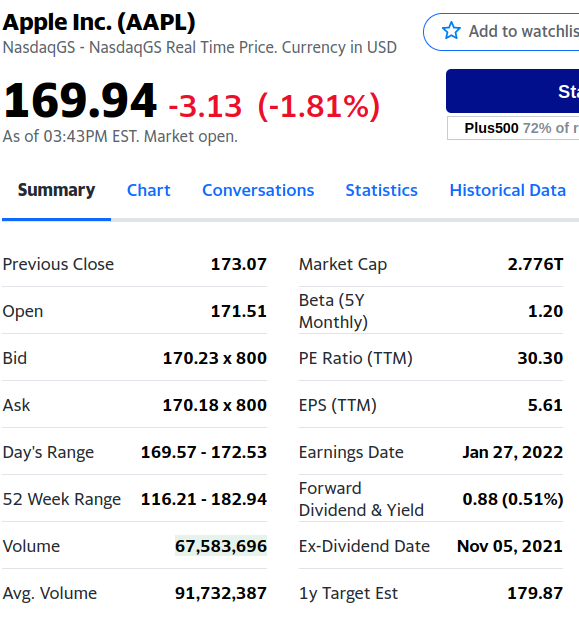

In [194]:
aapl_call_t0 = pd.read_csv('APPL_0.csv')
aapl_call_t1 = pd.read_csv('APPL_1.csv')
aapl_call_t3 = pd.read_csv('APPL_3.csv')

def get_maturity(df):
    return (pd.to_datetime(df.Expiry) - datetime.now()).dt.days / 360

aapl_call_t0['maturity'] = get_maturity(aapl_call_t0)
aapl_call_t1['maturity'] = get_maturity(aapl_call_t1)
aapl_call_t3['maturity'] = get_maturity(aapl_call_t3)

In [197]:
aapl_eiv_data_t1 = pd.DataFrame()

aapl_eiv_data_t1['date'] = aapl_call_t1.Quote_Time
# aapl_eiv_data_t1['return'] = get_asset_return('aapl', pd.to_datetime(aapl_call_t0.Quote_Time), pd.to_datetime(aapl_call_t1.Quote_Time))
aapl_eiv_data_t1['return'] = (aapl_call_t1.Underlying_Price - aapl_call_t0.Underlying_Price) / aapl_call_t0.Underlying_Price
aapl_eiv_data_t1['maturity'] = aapl_call_t1.maturity
aapl_eiv_data_t1['delta'] = aapl_call_t1.apply(
    lambda x:  delta_call(
        x.Underlying_Price, x.Strike, x.maturity, 0.054, 0.051, x.IV
    ), 
    1
)
aapl_eiv_data_t1['iv_change'] = aapl_call_t1.IV - aapl_call_t0.IV

aapl_eiv_data_t1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in double_scalars



,date,return,maturity,delta,iv_change
0,2022-01-18 17:44:49,-0.001755,0.002778,0.999858,-2.046878
1,2022-01-18 17:44:49,-0.001755,0.002778,0.999858,0.000000
2,2022-01-18 17:44:49,-0.001755,0.002778,0.999858,-1.941409
3,2022-01-18 17:44:49,-0.001755,0.002778,0.999858,0.000000
4,2022-01-18 17:44:49,-0.001755,0.002778,0.999858,-1.882815
...,...,...,...,...,...
1943,2022-01-18 17:44:49,-0.001755,0.663889,0.000000,0.000000
1944,2022-01-18 17:44:49,-0.001755,0.002778,0.004414,0.011719
1945,2022-01-18 17:44:50,-0.001763,0.411111,0.240822,0.002136
1946,2022-01-18 17:44:49,-0.001755,0.663889,0.282274,0.001831


In [196]:
aapl_eiv_data_t3 = pd.DataFrame()

aapl_eiv_data_t3['date'] = aapl_call_t3.Quote_Time
# aapl_eiv_data_t3['return'] = get_asset_return('aapl', pd.to_datetime(aapl_call_t0.Quote_Time), pd.to_datetime(aapl_call_t3.Quote_Time))
aapl_eiv_data_t3['return'] = (aapl_call_t3.Underlying_Price - aapl_call_t0.Underlying_Price) / aapl_call_t0.Underlying_Price
aapl_eiv_data_t3['maturity'] = aapl_call_t3.maturity
aapl_eiv_data_t3['delta'] = aapl_call_t3.apply(
    lambda x:  delta_call(
        x.Underlying_Price, x.Strike, x.maturity, 0.05, 0.051, x.IV
    ), 
    1
)
aapl_eiv_data_t3['iv_change'] = aapl_call_t3.IV - aapl_call_t1.IV

aapl_eiv_data_t3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in double_scalars



,date,return,maturity,delta,iv_change
0,2022-01-18 19:24:18,0.000186,0.002778,0.999858,-0.828124
1,2022-01-18 19:24:18,0.000186,0.002778,0.999858,0.000000
2,2022-01-18 19:24:18,0.000186,0.002778,0.999858,-0.781249
3,2022-01-18 19:24:18,0.000186,0.002778,0.999858,0.000000
4,2022-01-18 19:24:18,0.000186,0.002778,0.999858,-0.781249
...,...,...,...,...,...
1943,2022-01-18 19:24:18,0.000186,0.663889,0.000000,0.000000
1944,2022-01-18 19:24:18,0.000186,0.002778,0.004408,-0.013184
1945,2022-01-18 19:24:18,0.000186,0.411111,0.240562,-0.002380
1946,2022-01-18 19:24:18,0.000186,0.663889,0.281975,-0.002014


In [ ]:
aapl_eiv_data = pd.concat([aapl_eiv_data_t1, aapl_eiv_data_t3])
aapl_eiv_data

,date,return,maturity,delta,iv_change
0,2022-01-18 17:44:49,-0.000823,0.005556,0.999658,-2.046878
1,2022-01-18 17:44:49,-0.000823,0.005556,0.999716,0.000000
2,2022-01-18 17:44:49,-0.000823,0.005556,0.999655,-1.941409
3,2022-01-18 17:44:49,-0.000823,0.005556,0.999716,0.000000
4,2022-01-18 17:44:49,-0.000823,0.005556,0.999652,-1.882815
...,...,...,...,...,...
1943,2022-01-18 19:24:18,0.000235,0.666667,0.000000,0.000000
1944,2022-01-18 19:24:18,0.000235,0.005556,0.050727,-0.013184
1945,2022-01-18 19:24:18,0.000235,0.413889,0.242611,-0.002380
1946,2022-01-18 19:24:18,0.000235,0.666667,0.283293,-0.002014
